# Income Prediction from Census Data

## Summary
Can we predict who earns a high income using only demographic data? This report explores that question using the 1994 [Census Income dataset](https://archive.ics.uci.edu/dataset/2/adult). The analysis encompasses data cleaning, exploratory analysis, feature engineering, model development, and business considerations.

### Key Results:
- Final Models: LGBM achieved the highest accuracy, with 87.4% cross-validated accuracy. However, GLM still achieved good accuracy, with 84.5%, and may be the best model of the two depending on the business case.

- Top 5 Predictive Features (LGBM):
    - Capital Net: Investment income indicator
    - Age: Life-cycle earnings pattern
    - Hours per Week: Full-time vs part-time distinction
    - Education: Human capital investment
    - Relationship = Married: Household income dynamics

## Motivation for the Prediction Task

Accurately predicting individual income levels has significant practical applications across multiple sectors. For example:

**Government & Public Policy:**
- **Welfare Eligibility Screening:** In countries lacking centralized income tracking (e.g., UK), predictive models can help identify individuals likely eligible for means-tested benefits (Winter Fuel Payment, Universal Credit) without intrusive income verification.

**Non-Profit Sector:**
- **Donor Prospecting:** Charities often use crude proxies (e.g., age, postcode) for wealth assessment during door-to-door fundraising. Data-driven income prediction can improve targeting efficiency, reducing wasted outreach while respecting privacy.

## Explanatory Data Analysis

### Dataset Overview
The dataset comes from the UCI Machine Learning Repository. The prediction task is to determine whether an individual's income exceeds USD 50,000 per year.

**Dataset Characteristics**:
- Samples: 48,842 individuals
- Original Features: 15 variables
- Target Variable: Binary income classification (<=50,000, >50,000)
- Source: US Census Bureau, 1994

**Distribution**:

Numerical distributions vary significantly. While 'Age' shows a smooth natural spread, 'Hours-per-week' is heavily concentrated (see visualization). Recognizing these distinct patterns, natural variance vs. structural concentration, is critical for accurate modeling.

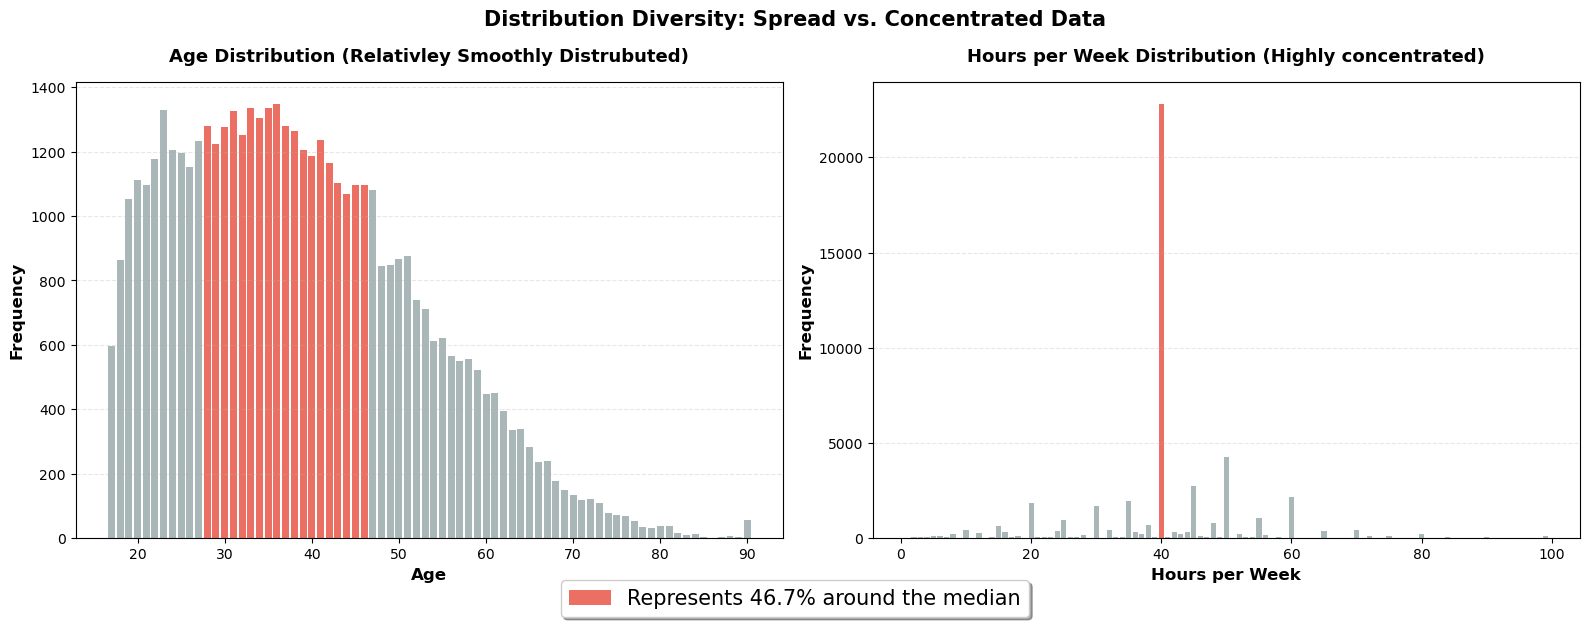

In [ ]:
import polars as pl
from income_predict_d100_d400.robust_paths import DATA_DIR
from income_predict_d100_d400.final_report import plots

parquet_path = DATA_DIR / 'census_income.parquet'

df_raw = pl.read_parquet(parquet_path)

plots.distribution_variety(df_raw)

### Initial Data Quality Assessment

There were a number of minor data quality issues with the dataset, many of which could be resolved by simple transformations of the dataset. Below I visualise some of the data quality problems that needed to be dealt with.

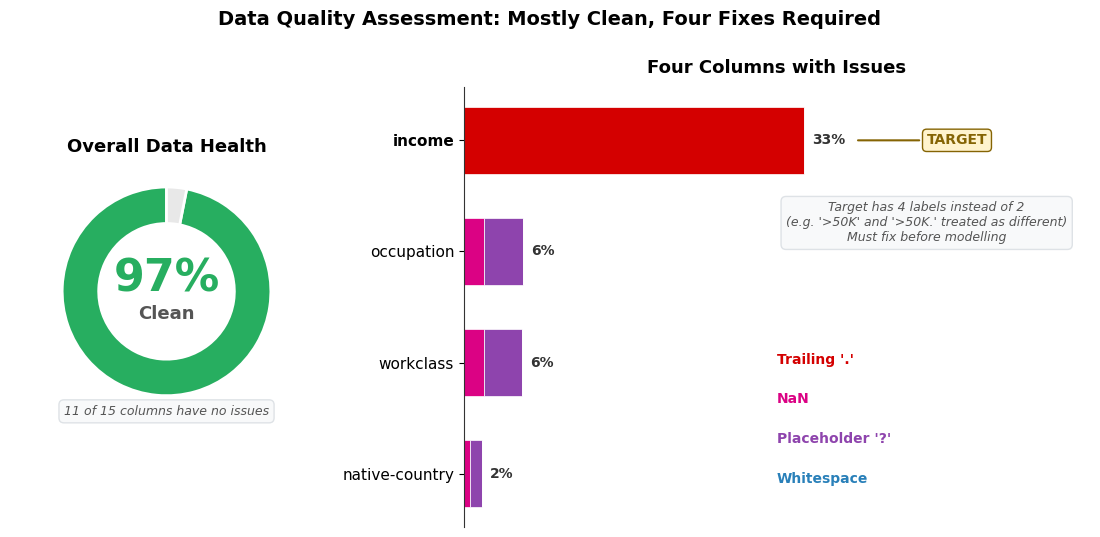

In [12]:
plots.visualize_data_quality_issues(df_raw)

#### Cleaning Steps Applied

- Add unique ID column (there were 29 duplicates, this isn't unexpected as some people will have the same demographics. Adding unique ID allows us to tell these individuals apart)
- Basic column name cleaning
- Binarize marital_status (is_married_healthy)
- Remove ignored columns
- Clean target feature
- Binarize income data (1 for '>50,000', 0 for '<=50,000') and rename to 'high_income'
- Binarize sex and rename to is_female
- Binarize race into two columns, is_white and is_black
- Replace '?' values with pandas NaN
- Trim whitespace from all string values
- Order and transform education. Change datatype from str to int (e.g. 'Preschool' = 1 < '1st-4th' = 2 < ... < 'Doctorate' = 16)
- Transform capital-gain and capital-loss into a single column, capital_net
- Simplify relationship column. Bundle 'Wife' and 'Husband' values into one, 'Married'


In [13]:
from income_predict_d100_d400 import cleaning

df_clean = cleaning.full_clean(df_raw)

## Feature Selection & Engineering

### Feature Engineering Approach

To ensure robust performance across both models, I implemented a shared preprocessing pipeline, with specific enhancements driven by the GLM's sensitivity:

1. **Shared Preprocessing (Both Models)**:

    - **Imputation**: I prevented leakage by imputing missing values within the cross-validation pipeline (median for numeric, 'missing' category for categorical)

    - **Encoding**: Nominal variables were One-Hot Encoded. While LGBM can handle categories natively, OHE ensures a consistent feature space for direct model comparison

2. **GLM-Specific Enhancements**:

    - **Scale & Skew**: Unlike the tree-based LGBM which is invariant to monotonic transformations, the GLM requires strictly scaled data. I applied our custom SignedLogTransformer followed by StandardScaler to all numeric features to ensure efficient convergence

    - **Interactions**: I manually engineered an age_x_education interaction term. The LGBM learns these non-linearities automatically, but the GLM requires explicit features to capture life-cycle effects

### Feature Selection 
Selection was driven by EDA findings and economic intuition:

- **Numeric**: age, hours_per_week, and education (ordinally encoded to preserve rank)

- **GLM Interaction**: I manually engineered an age_x_education interaction term to capture changing returns to education over the life-cycle—a non-linear relationship the LGBM learns implicitly but the GLM requires explicitly

- **Categorical**: occupation, work_class, and relationship were retained for their strong correlation with income. marital_status, sex, and race were binarized were binarized

- **Exclusions**: I removed fnlwgt (non-predictive), education-num (redundant)

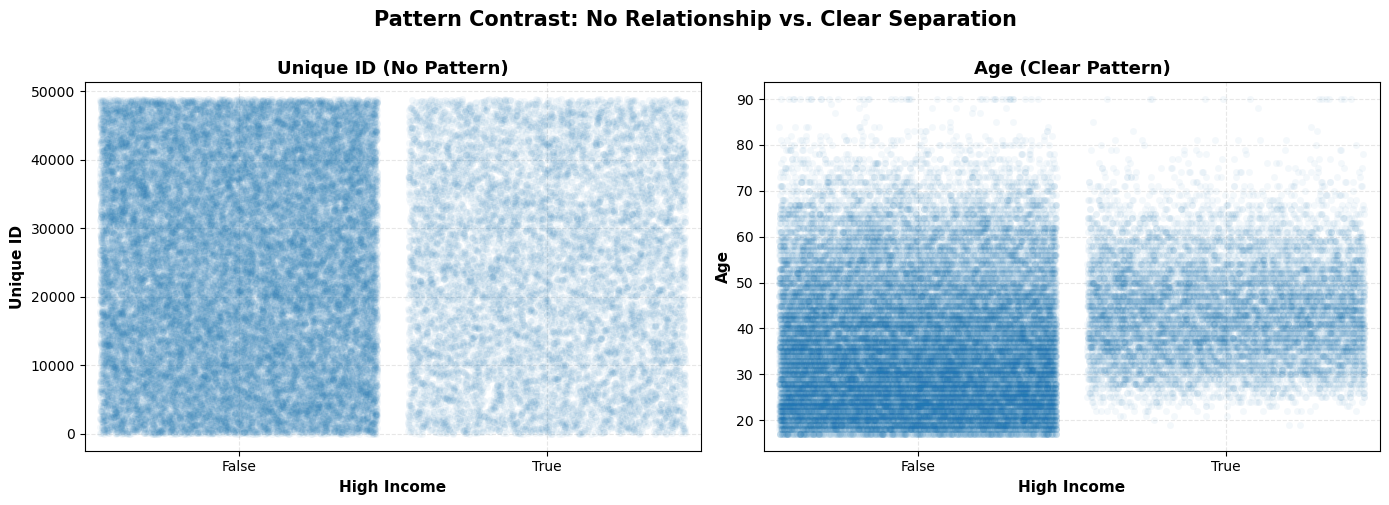

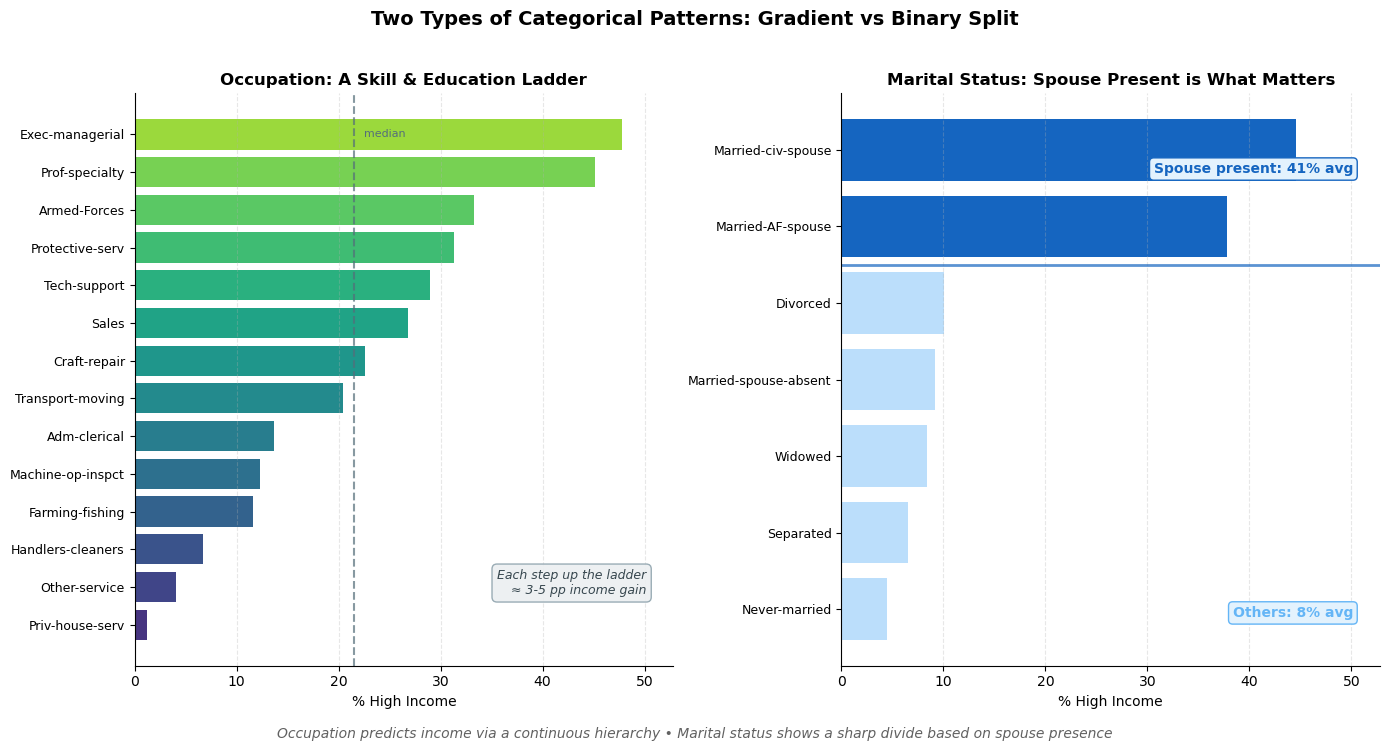

In [14]:
plots.correlation_compare(df_clean)
plots.categorical_pattern_contrast(df_clean)

### Train-Test Split Strategy

**Split Methodology**:
- Method: Hash-based splitting on unique_id (80% train, 20% test)
- Why: Hash function ensures reproducible split across runs. This ensures no data leakage

**Cross-Validation for Hyperparameter Tuning**:
- Method: 5-fold Stratified K-Fold on training set only
- Why: Stratification preserves class balance in each fold; multiple folds provide robust performance estimates and reduce overfitting to a single validation split

## Modelling

### Model Selection

Two complementary approaches were selected:

1. Generalized Linear Model (GLM)
    - For GLM implementation, I selected the SGDClassifier with log-loss. This allowed for direct tuning of the alpha and l1_ratio regularization parameters
2. LightGBM (LGBM)
    - For the LGBM implementation, I utilized the standard lightgbm.LGBMClassifier. 

**Why GLM?**:

- Interpretability: Coefficients show linear relationship between each feature and the target
- Baseline: Establishes performance floor. Simpler models preferred if comparable
- Fast Training: Scales well to large datasets
- Assumptions: Appropriate if relationships are approximately linear

**Why LGBM?**:

- Non-linear Relationships: Captures complex interactions between features
- Feature Interactions: Automatically learns combinations without manual engineering
- Robust: Handles missing values, outliers, and mixed feature types well
- Performance: Generally highly accurate, in comparisson to GLM and other boosting models
- Feature Importance: Provides interpretable feature rankings

### Evaluation Approach

#### Metric Selection

Metric Selection and Rationale:

| Metric | Why Important | Interpretation |
|--------|---------------|----------------|
| **Accuracy** | Overall correctness | % of correct predictions |
| **Precision** | Minimize false positives | Of predicted high-income, % actually high-income |
| **Recall** | Minimize false negatives | Of actual high-income, % correctly identified |
| **F1-Score** | Balance precision/recall | Harmonic mean; useful for imbalanced data |
| **ROC-AUC** | Ranking quality | Probability of ranking random positive > negative |
| **Log Loss** | Probability calibration | Penalizes confident wrong predictions |


**Primary Metric/s**: It depends on the exact business question. For example, charity donor prospecting will likely want a model with high precision and Log Loss, so that they can target people that are most likely to have high-income.

#### Evaluation Strategy

- Train Set: Used for model training and hyperparameter tuning (with cross-validation)
- Test Set: Held out for final evaluation only (no model selection on test set)
- Cross-Validation: 5-fold stratified CV during hyperparameter tuning
    - Ensures robust parameter selection
    - Reduces overfitting to single validation split
    - Maintains class balance in each fold
- Preventing Overfitting:
    - Separate train/test split (no test set leakage)
    - Cross-validation for hyperparameter selection
    - Regularisation for GLM
    - Early stopping from LGBM

### Hyperparameter Tuning

#### GLM Tuning

**Parameters selected**:
| Parameter | Search Space | Purpose | Baseline Value | Tuned Value |
|-----------|--------------|---------|----------------|----------------|
| `alpha` | 10^-4 to 10^-1 (log-uniform) | Regularization strength (higher = more regularization) | 0.0001 | **0.000861** |
| `l1_ratio` | 0 to 1 (uniform) | Balance between L1 (Lasso) and L2 (Ridge) penalty | 0.15 | **0.520** |

**Tuning Process:**
- **Method:** Randomized search (more efficient than grid search for continuous parameters)
- **Iterations:** 50 random combinations sampled
- **Cross-Validation:** 5-fold stratified ensures robust evaluation
- **Search Strategy:** Log-uniform for `alpha` (covers multiple orders of magnitude)

#### LGBM Tuning

**Parameters selected**:
| Parameter | Search Space | Purpose | Baseline Value | Tuned Value |
|-----------|--------------|---------|----------------|----------------|
| `learning_rate` | 0.01 to 0.2 (log-uniform) | Controls step size in gradient descent | 0.1 | **0.158** |
| `n_estimators` | 50 to 200 (integer) | Number of boosting rounds (trees) | 100 | **89** |
| `num_leaves` | 10 to 60 (integer) | Maximum leaves per tree (complexity) | 31 | **30** |
| `min_child_weight` | 0.0001 to 0.002 (log-uniform) | Minimum sum of instance weight in leaf (regularization) | 0.001 | **0.00013** |

**Note on Early Stopping**: Instead of utilizing early stopping, I included the number of boosting rounds (n_estimators) directly in the hyperparameter search space. This allowed the optimal number of trees to be selected via Stratified K-Fold Cross-Validation, ensuring the model complexity was validated robustly across multiple data splits rather than a single hold-out set.

**Tuning Process:**
- **Method:** Randomized search (efficient for large search space)
- **Iterations:** 20 combinations (LGBM slower to train than GLM)
- **Cross-Validation:** 5-fold stratified


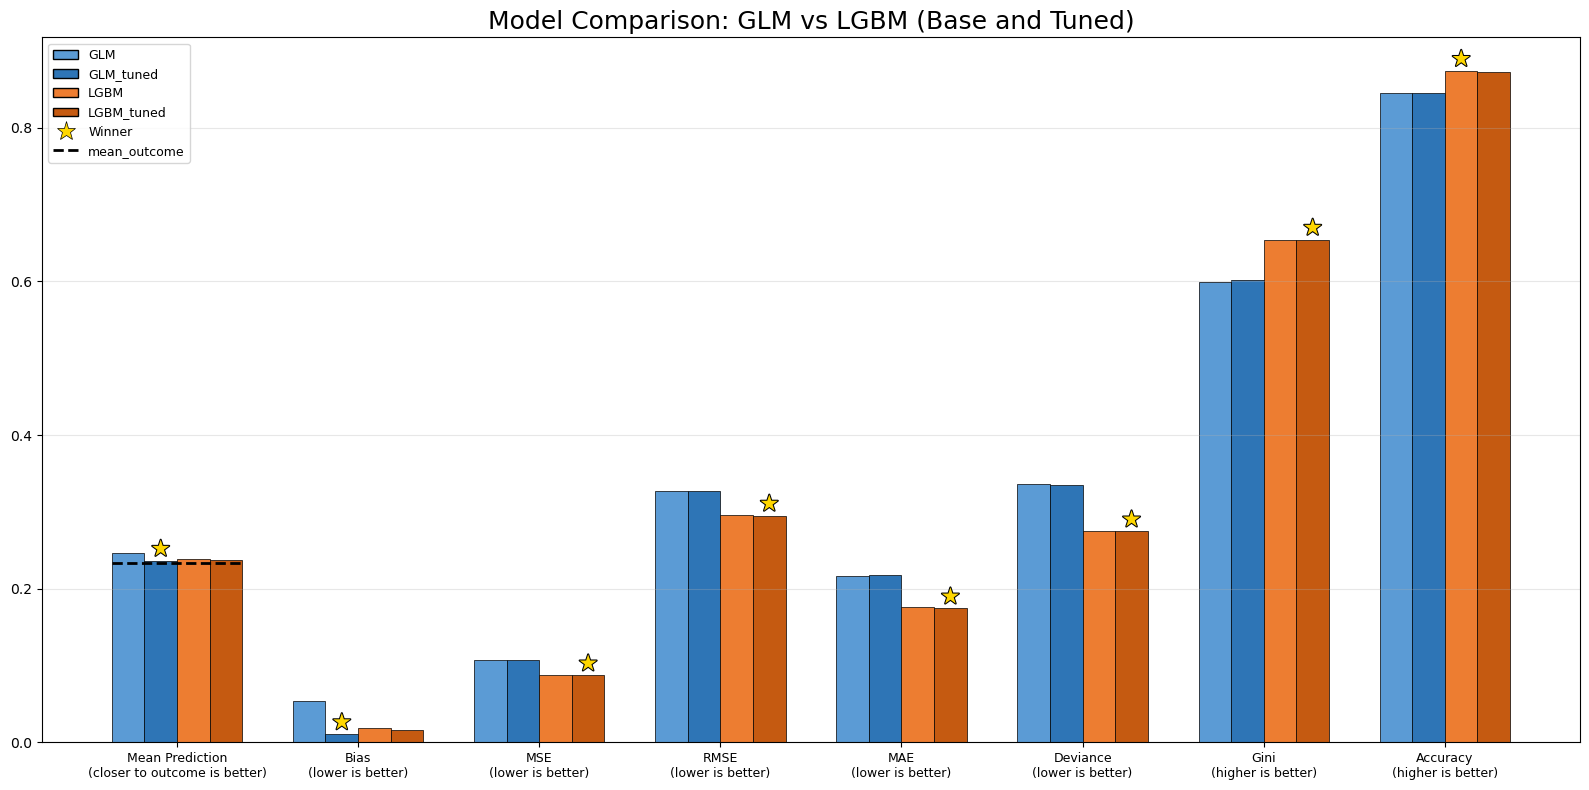

In [15]:
plots.model_comparison()

**Performance Interpretation:**

- LGBM outperforms GLM across nearly all metrics.
- The most striking result is GLM's bias reduction after tuning, 80% improvement. This means the baseline GLM was systematically over-predicting and tuning corrected this calibration issue
- LGBM showed modest gains from tuning, with small improvements across metrics. This indicates the baseline LGBM hyperparameters were already near-optimal for this dataset.

I shall only focus on the tuned models moving forward. 

**Classification Performance Analysis**

Classification performance matters because it reveals not just overall accuracy, but where the model is accurate, i.e. false positives vs false negatives.

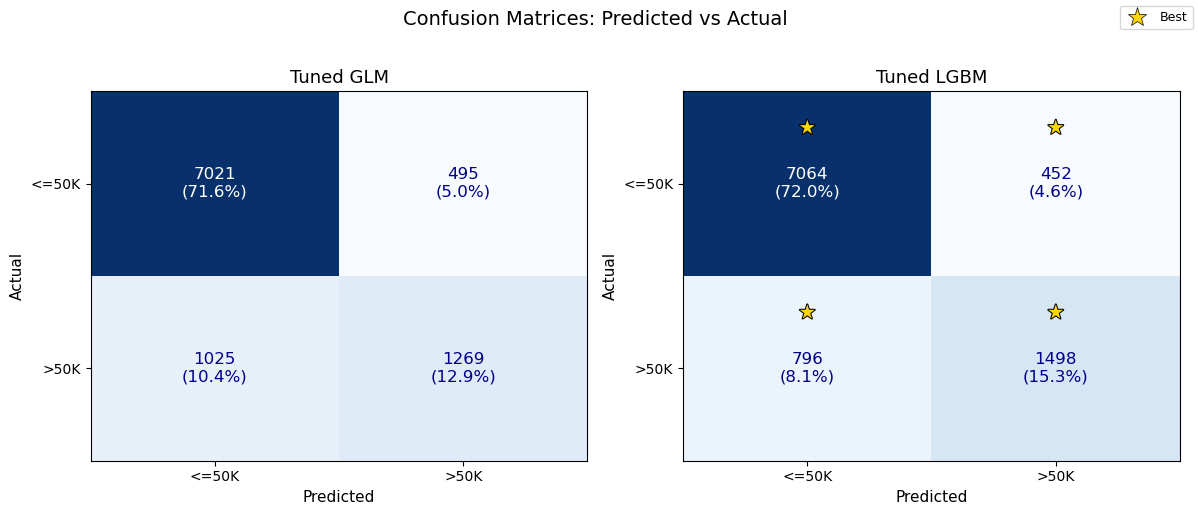

In [16]:
plots.confusion_matrix()

**Confusion Matrix Insights**:

LGBM beats GLM across all metrics in the classification analysis.

Given LGBM is better at avoiding false positives and false negatives, there is no need to consider which is more important. However, if one model was better at false positives and the other better at false negatives, I would need to consider the business implications to determine which model would be preferred.

**Calibration and ROC Analysis**

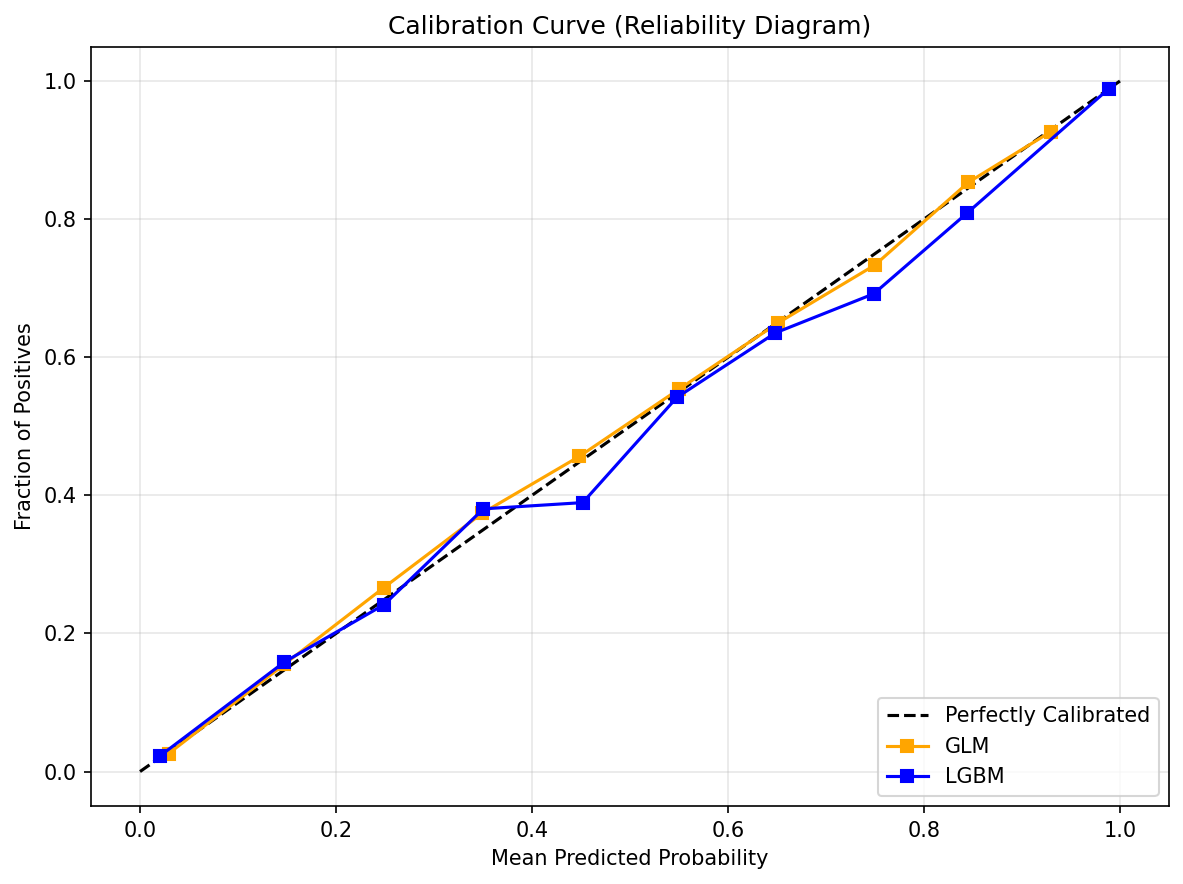

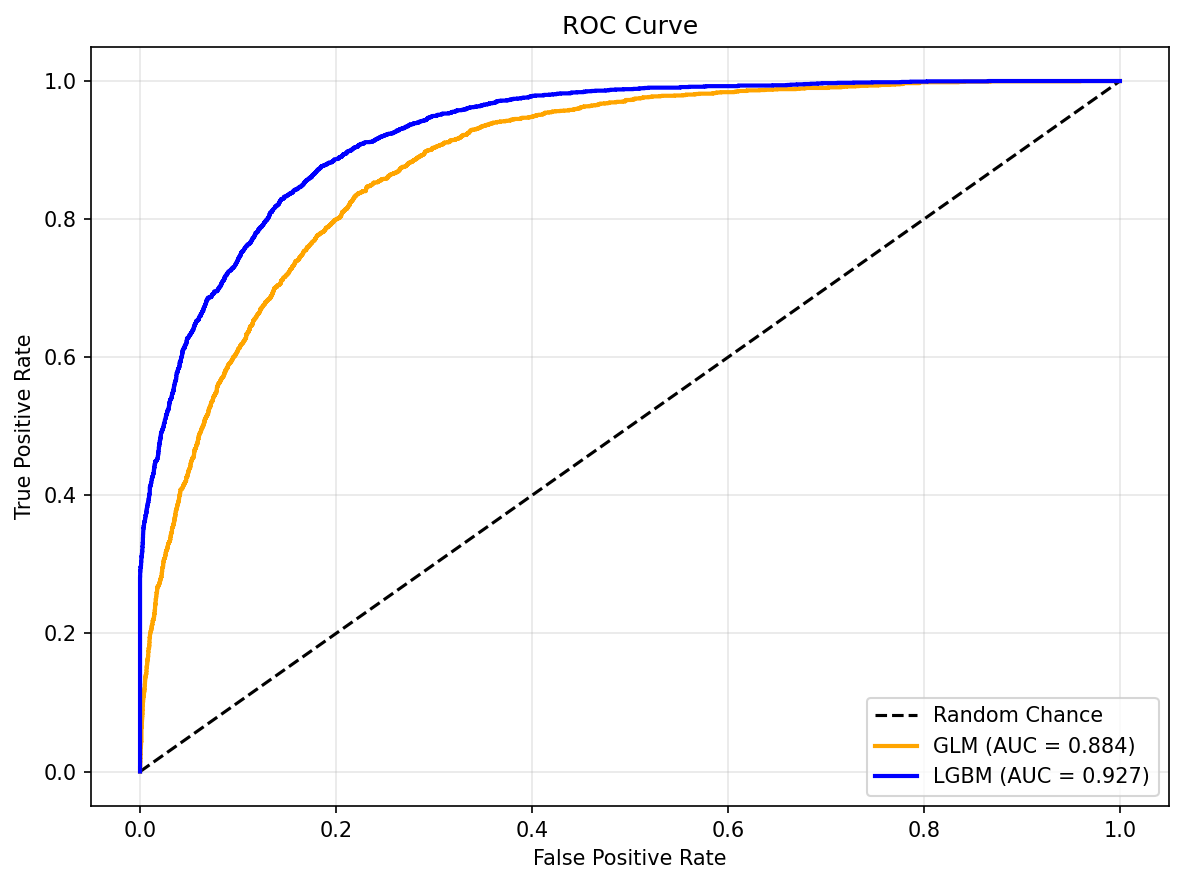

In [ ]:
from IPython.display import display, Image

from income_predict_d100_d400.robust_paths import PLOTS_DIR

display(Image(filename=PLOTS_DIR / 'calibration_plot.png'))
display(Image(filename=PLOTS_DIR / 'roc_curve_plot.png'))

**Calibration and ROC Insights**

Both charts togehter together show the trade-off between reliability (how accurate the predicted probabilities are) and discrimination (how well the model separates high-income from non-high-income earners).

**GLM (best for reliability)**: Validating its log_loss objective, the GLM achieves near-perfect calibration, meaning its risk estimates are mathematically precise.

**LGBM (best for discrimination)**: While slightly over-confident, the LGBM is the superior classifier, significantly outperforming the GLM at separating high-income.

**Combined Insight**: The models excel at different tasks. The LGBM is the better choice for targeting and generating 'top lists' (ranking), whereas the GLM is safer for financial calculations where the exact probability value matters (risk assessment).

**Feature Importance Comparison**

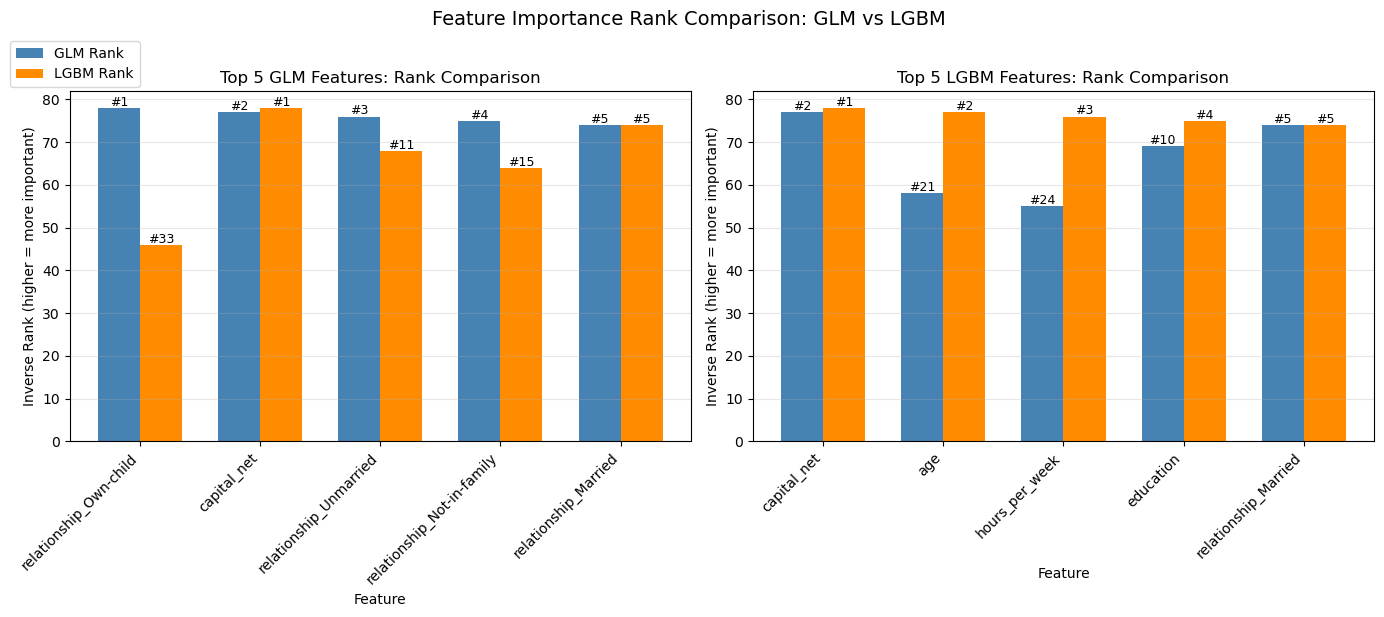

In [18]:
plots.feature_importance_rank()

**Feature Importance Insights**

The Feature Importance chart shows that the GLM model and LGBM model can rate particular features very similarly, as well as very differently. This highlights the  differences in how these models learn patterns from data. GLM relies on linear, individual correlations, whereas LGBM can captures non-linear interactions and handles feature redundancy. For example, GLM ranks 'Own-child' highly compared to LGBM, this suggests that there is a relationship with income, its possible to extract much of the signal through other features like age and hours worked.


**Partial Dependence Analysis**

Below are two Partial Dependence charts provinding insights into predicting high-income, as well as understanding how GLM and LGBM models work generally.


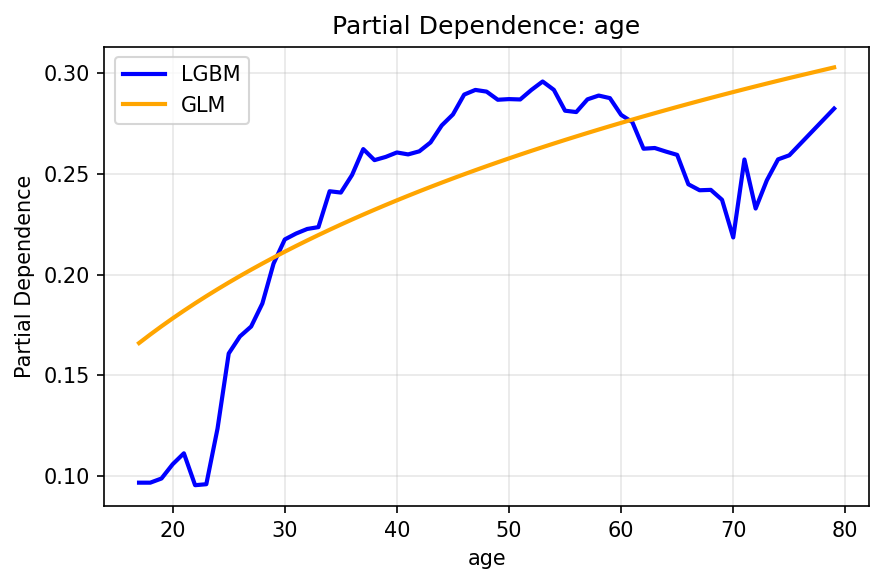

In [ ]:
display(Image(filename=PLOTS_DIR / 'partial_dependence_age.png'))

**Partial Dependence: Age**

Age is a different story. GLM is struggling to capture the nuance of the data, which LGBM does capture. Intuitively, it makes sense that income peaks at around middle-age. 

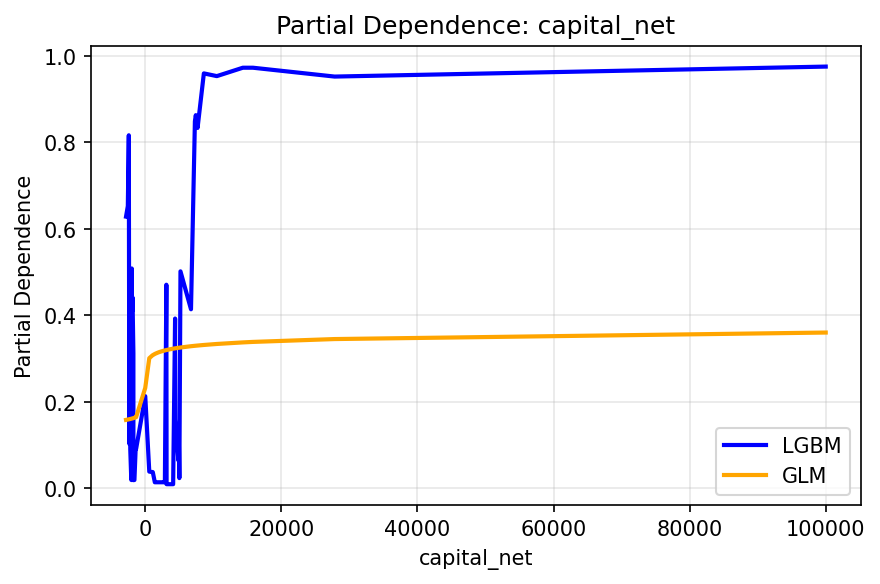

In [ ]:
display(Image(filename=PLOTS_DIR / 'partial_dependence_capital_net.png'))

**Partial Dependence: Net Capital**

GLM predicts reduced high-income probability for negative Net Capital, contrasting with LGBM's initially high dependence. LGBM exhibits significant volatility and sharp spikes, suggesting overfitting to sparse data. The true relationship likely lies between these models; intuitively, negative capital implies prior asset ownership, supporting a stronger correlation with high-income than the GLM suggests.

## Future Improvements & Business Considerations

### Dataset Improvements

**Richer features**: geographic context (state, cost of living), detailed education (institution type, field of study), and employment history (industry, tenure).

**Target granularity**: The binary high-income threshold limits insight. Continuous income prediction or a low-income flag would enable more nuance, though at higher overfitting risk.

**Data quality and volume**: Missing values in occupation and native-country couldn't be resolved. More critically, edge cases like non-zero capital gains were sparse, likely causing LGBM to overfit on these segments.

**Temporal relevance**: The 1994 Census is dated. Multiple census years would reveal income trends over time, and a recent UK census would better serve UK-based organizations.

### Modelling Improvements

#### Other Models

Only two models were used in this analysis, however, there is a vast array of other alternatives. Notably for this anlysis, GAMs could be a good alternative (for interpretable non-linearity).

#### Advanced Feature Engineering

With more time I would have liked to delve into some of the following feature engineering techniques.

- **More Manual Feature Interactions (for GLM)**
    - Education × Occupation (PhD in healthcare vs PhD in academia)
    - Hours_per_week × Occupation (overtime matters differently by job)
    - Implementation: Use PolynomialFeatures or manual feature creation

- **Polynomial analysis of features**
    - Capital_net transformations (log, sqrt) for skewed distribution
    - Could use sklearn's PolynomialFeatures() function

- **Binning of features**
    - Age groups (young adult, mid-career, pre-retirement)
    - Hours worked categories (part-time, full-time, overtime)
    - This may help capture non-linear effects more explicitly, especially with GLM

#### Hyperparameter Tuning Extensions

Sklearn offers many other options for tuning GLM and LGBM models that I did not touch on. Had I, perhaps I would have seen a real improvement in the tuned models vs baseline models.

### Critical Business Considerations

- Since detailed census data is difficult to access, this serves as a 'toy model' for feasibility. In a business context, this stage would help evaluate whether the significant investment required for a production-ready solution is worthwhile.

- Success may not require productionalization. The model's outputs, specifically feature importance and partial dependence, can be valuable on their own, such as helping a charity refine its donor wealth assessments.

- Ultimately, the goal is business value. If an organization seeks insights rather than a deployed prediction engine, it makes little sense to choose a fancy flexible model that sacrifices interpretability.

## Conclusion

This analysis demonstrates that predicting income from demographics is feasible, but the 'best' model depends on what exactly you need. For insights and interpretability, the GLM delivers. For pure predictive power, the LGBM wins. Perhaps most importantly: even without deploying a model, the feature importance and partial dependence plots alone could help an organizations rethink how they identify high income individuals.